In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import CLIPModel, CLIPImageProcessor
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Data: use CLIP normalization ---
processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")
MEAN = processor.image_mean
STD  = processor.image_std
SIZE = processor.size["shortest_edge"] if isinstance(processor.size, dict) else processor.size

transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

train_dir = "data_classification/augmented/train"
test_dir  = "data_classification/augmented/test"

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir,  transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,  num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

# --- Model: CLIP vision encoder + binary head ---
clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", weights_only=False).to(device)

# Freeze ALL CLIP params (vision encoder + visual projection + text stuff)
for p in clip.parameters():
    p.requires_grad = False

# Feature dim after visual projection
feat_dim = clip.visual_projection.out_features  # CLIP's embedding size

# Binary head: 1 logit
head = nn.Linear(feat_dim, 1).to(device)
head.requires_grad_(True)

optimizer = optim.Adam(head.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

In [5]:
def extract_image_features(imgs: torch.Tensor) -> torch.Tensor:
    """
    imgs: (N,3,H,W) already CLIP-normalized.
    Returns: (N, feat_dim) projected image embeddings.
    """
    with torch.no_grad():  # backbone frozen; saves memory
        vis_out = clip.vision_model(pixel_values=imgs)   # .pooler_output shape (N, hidden)
        pooled = vis_out.pooler_output
        feats = clip.visual_projection(pooled)           # (N, feat_dim)
    return feats

def train_one_epoch():
    head.train()
    total_loss = 0.0
    for imgs, labels in tqdm(train_loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.float().unsqueeze(1).to(device, non_blocking=True)  # (N,1)

        feats = extract_image_features(imgs)   # (N, feat_dim)
        logits = head(feats)                   # (N,1)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def evaluate():
    head.eval()
    total = 0
    correct = 0
    total_loss = 0.0
    for imgs, labels in tqdm(test_loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        labels_float = labels.float().unsqueeze(1).to(device, non_blocking=True)

        feats = extract_image_features(imgs)
        logits = head(feats)
        total_loss += criterion(logits, labels_float).item() * imgs.size(0)

        preds = (torch.sigmoid(logits).squeeze(1) > 0.5).long().cpu()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return correct / total, total_loss / total


In [6]:
epochs = 10
for ep in range(epochs):
    tr_loss = train_one_epoch()
    acc, val_loss = evaluate()
    print(f"Epoch {ep+1}/{epochs} | train_loss {tr_loss:.4f} | val_loss {val_loss:.4f} | acc {acc:.3f}")


Epoch 1/10 | train_loss 0.6131 | val_loss 0.5826 | acc 0.724


Epoch 2/10 | train_loss 0.5529 | val_loss 0.5470 | acc 0.724


Epoch 3/10 | train_loss 0.5255 | val_loss 0.5264 | acc 0.724


Epoch 4/10 | train_loss 0.5034 | val_loss 0.5063 | acc 0.719


Epoch 5/10 | train_loss 0.4859 | val_loss 0.4917 | acc 0.719


Epoch 6/10 | train_loss 0.4721 | val_loss 0.4767 | acc 0.733


Epoch 7/10 | train_loss 0.4592 | val_loss 0.4651 | acc 0.756


Epoch 8/10 | train_loss 0.4482 | val_loss 0.4567 | acc 0.742


Epoch 9/10 | train_loss 0.4384 | val_loss 0.4458 | acc 0.760


Epoch 10/10 | train_loss 0.4300 | val_loss 0.4362 | acc 0.765


              precision    recall  f1-score   support

    Negative     0.7624    0.9809    0.8579       157
    Positive     0.8000    0.2000    0.3200        60

    accuracy                         0.7650       217
   macro avg     0.7812    0.5904    0.5890       217
weighted avg     0.7728    0.7650    0.7092       217

[[154   3]
 [ 48  12]]


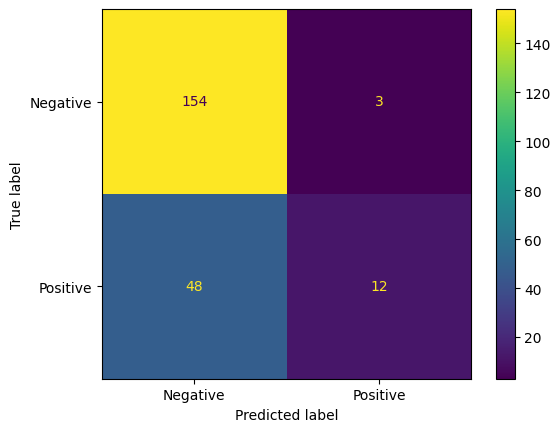

In [7]:

@torch.no_grad()
def collect_preds():
    head.eval()
    y_true, y_pred = [], []
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        feats = extract_image_features(imgs)
        logits = head(feats)
        preds = (torch.sigmoid(logits).squeeze(1) > 0.5).long().cpu().numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)
    return y_true, y_pred

y_true, y_pred = collect_preds()
print(classification_report(y_true, y_pred, target_names=train_dataset.classes, digits=4))
cm = confusion_matrix(y_true, y_pred)
print(cm)
ConfusionMatrixDisplay(cm, display_labels=train_dataset.classes).plot()
plt.show()